Import

In [2]:
import numpy as np
import pandas as pd
import os
import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')

pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 40)

%matplotlib inline

Data cleaning

Data manipulation class

TODO

- drop ready, eyecal fields from tidy...shiiiiiit i hate this data
- correct boards on hists (they probably have post-move board state)


In [26]:
class Tidy(object):
    
    """
        Tidy does several things (probably more than it really should)
        It loads data from processed eyetracking files and unprocessed game data files
        It then merges the data into a longform "tidy" dataset with an entry for each event, indexed by the time
        at which said event occurred
        And finally, it generates histograms for each move a subject made for their eye and mouse locations
    """
    
    def __init__(self, initials, sub_no=0):
        print(initials) # show who
        
        # column labels for input and output data
        self.columns = [
            'idx', 'subid', 'color', 'gi', 'mi', 'status', 'bp', 'wp', 'zet', 'rt', 'tstamp', 
            'mouset', 'mousex', 'rt_comp', 'tstamp_comp' 
                        ]
        self.tidy_cols = ['tstamp', 'eyex_raw', 'eyey_raw', 'eyex_tr', 'eyey_tr', 
                          'mousex', 'mousey', 'dt', 'etile', 'mtile']
        
        # params
        self.subject = initials
        self.sub_no = sub_no
        
        # load raw
        self.data = self.load_games()
        self.eye = self.load_eye()
        
        # merge mousetracking and eyetracking into big tidy data
        self.tidy = self.make_tidy()
        
        # make histograms
        self.mhist, self.ehist = self.make_hists()
        
        self.allh = self.agg_hists()
        
    def load_games(self):
        # load game data
        d = pd.read_csv('../../../Data/2_eye/Game/Raw/'+self.subject+'.csv', 
                              names=self.columns)
        
        # strip computer moves
        d = d.loc[d.rt.astype(int)>0, self.columns[1:]]
        
        # add timestamp and rt for computer
        d.loc[:, 'tstamp_comp'] = d.tstamp.astype(int) - d.rt.astype(int)
        d.loc[:, 'rt_comp'] = d.tstamp_comp - d.tstamp.astype(int).shift(1)
        d.loc[:, 'subject'] = self.sub_no
        d = d.reset_index(drop=True)
        return d
    
    def load_eye(self):
        eye = pd.read_csv('../../../Data/2_eye/Clean/new_'+self.subject+'_events.csv')
        eye = eye.loc[~pd.isnull(eye.exp_time), :]
        eye.loc[:, 'exp_time'] = (eye.exp_time*1000).astype(int)
        return eye
    
    def make_tidy(self):
        """Create longform data sheet and fill appropriate values"""
        
        ### INITIALIZE ###
        b = self.data.tstamp.astype(int)
            # all the timestamps in game data
        eye_time_range = (self.eye.exp_time <= b.max()) # (1000*self.eye.exp_time >= b.min()) & 
            # all eye event times less than final game event time
        e = self.eye.loc[eye_time_range, :]
        print(len(e))
            # we'll use this view later, so save to 'e'
        
        tidy = pd.DataFrame(index=np.arange(b.max() + 1 - b.min()),  columns=self.tidy_cols)
            # new frame for longform data
        tidy.loc[:, 'tstamp'] = np.arange(b.min(), b.max()+1, 1)  
            # set timestamps in tidy
        
        ### MOUSE STUFF ###
        dm = self.data.loc[~pd.isnull(self.data.mouset), :]
            # selection of data where there is mousetracking data
            
        for idx in dm.index.values:
            # for each tracked observation
            mouset = dm.loc[idx, 'mouset']
                # select mouse timestamps
            mouset = mouset.split(',')
                # split them to a list
            mouset = np.array(mouset).astype(int) # np.array(list(map(int, mouset)))
                # convert to numpy int array
            mouset = mouset[mouset > int(dm.tstamp.values[0])]
                # select only those movements that occurred after first experiment obs
            mousexy = np.array([xy.split(',') for xy in dm.loc[idx, 'mousex'].split(';')]).astype(int)
                # split mousexy string into int array of (x, y) coordinate tuples
            mousexy = mousexy[mouset > int(dm.tstamp.values[0]), :]
                # select only movements after 1st obs
#             print(np.in1d(tidy.tstamp.values, mouset))
            tidy.loc[np.in1d(tidy.tstamp.values, mouset), ['mousex', 'mousey']] = mousexy
                # set tidy mouse x, y coordinates on appropriate timestamps
        
        ### EYE STUFF ###
        tidy.loc[np.in1d(tidy.tstamp.values, e.exp_time), 
            ['eyex_raw', 'eyey_raw', 'eyex_tr', 'eyey_tr', 'etile']
        ] = e.loc[:, ['raw_xloc', 'raw_yloc', 'transx', 'transy', 'tile']].values
#         print(tidy.loc[pd.notnull(tidy.etile), :])
            # set tidy's eye-event columns to appropriate values from eye tracking data
        
        ### NAN HANDLING ###
        no_obs = pd.isnull(tidy.mousex) & pd.isnull(tidy.eyex_raw)
            # select rows where there is neither mousex or eyex_raw data
        tidy = tidy.loc[~no_obs, :]
            # remove them
        
        for c in ['mousex', 'mousey']+['eyex_raw', 'eyey_raw', 'eyex_tr', 'eyey_tr', 'etile']:
            tidy.loc[:, c] = tidy.loc[:, c].fillna(method='ffill')
                # fill missing values DOWN (because values remain the same until a new event)
        
        ### CONVERT MOUSE TILE ###
        tidy.loc[:, 'mtile'] = self.mouse_to_tile(tidy.mousex, tidy.mousey)
        
        ### FILL DT (duration of an event)
        tidy.loc[:, 'dt'] = np.ediff1d(tidy.tstamp.values, to_begin=0)        

        return tidy
    
    def mouse_to_tile(self, x, y):
        top = 192
        bottom = 506
        left = 177
        right = 889
        height = bottom - top
        width = right - left
        newx = 9*(x - left) // width
        newy = 4*(y - top) // height

        return newx + 9*newy
            
    def export_tidy(self):
        self.tidy.to_csv('../../../Data/2_eye/Longform/'+self.subject+'.csv', index=False)
        return None
    
    def make_hists(self):
        
        ### INITIALIZE ###
        movehist = self.data.loc[:, ['subject', 'tstamp', 'tstamp_comp', 'status', 
                                     'color', 'bp', 'wp', 
                                     'zet', 'rt', 'rt_comp']].copy()
            # dataframe for move histograms

        for i in range(36):
            # for each tile
            movehist.loc[:, str(i)] = 0
                # add a column and set its value to 0
                
        eyehist = movehist.copy()
            # copy for eye histograms
            
        td = self.data
        tt = self.tidy
            # shortcut nuames
            
        movebounds = np.array([td.tstamp_comp.values.astype(int)+1, td.tstamp.values.astype(int)+1]).T
            # set bounds from timestamps for each observation (bounds are inclusive, so + 1)
            
        ### CALCULATE HISTOGRAMS ###
        for i, idx in enumerate(movehist.index.values):
            # for each observation
            lower, upper = movebounds[i, :]
                # extract bounds
            temp = tt.loc[(tt.tstamp>lower)&(tt.tstamp<upper), :]
                # select from tidy between bounds (inclusive)
            for j in range(36): ## REVISIT - instead of loop, can a pivot be used?
                # for each tile
                movehist.loc[idx, str(j)] = temp.loc[temp.mtile.astype(float)==j, 'dt'].astype(int).sum()
                eyehist.loc[idx, str(j)] = temp.loc[temp.etile.astype(float)==j, 'dt'].astype(int).sum()
                    # sum the dt spent looking at it with mouse/eye respectively

        return movehist, eyehist
    
    def agg_hists(self):
        
        ### INITIALIZE ###
        cols = ['subject', 'color', 'bp', 'wp', 'zet', 'rt', 'tstamp', 'tstamp_comp', 'status']
        mcols = list(map(lambda x: 'm' + str(x), range(36)))
        ecols = list(map(lambda x: 'e' + str(x), range(36)))
        allh = pd.DataFrame(index=self.data.index, columns=cols + mcols + ecols)
        allh.loc[:, cols] = self.data.loc[:, cols]
        
        ### CORRECT BOARDS ###
        for i in allh.index:
            if int(allh.loc[i, 'color']) == 0:
                ps = 'bp'
            else:
                ps = 'wp'  
            p, z = allh.loc[i, [ps, 'zet']]
            p = list(p)
            p[int(z)] = '0'
            allh.loc[i, ps] = ''.join(p)
        
        ### ASSIGN HISTS ###
        allh.loc[:, mcols] = self.mhist.loc[:, list(map(str, range(36)))].values
        allh.loc[:, ecols] = self.ehist.loc[:, list(map(str, range(36)))].values
        
        return allh

In [27]:
inits = [f[:2] for f in os.listdir('../../../Data/2_eye/Game/Raw/') if f[-3:]=='csv']

data = []
for ii, i in enumerate(inits):
    t = Tidy(i, sub_no=ii)
    
    data.append(t)

AN
12343
BA
7769
DL
13525
IA
17999
JA
9897
JL
15101
JP
13465
PO
13439
RG
11500
VL
17901


In [28]:
d = data[0]
d.eye.exp_time.values - d.eye.exp_time.values[0]

array([      0,       0,       0, ..., 2121928, 2121928, 2121928], dtype=int64)

In [29]:
DD = pd.concat([d.allh for d in data])
DD_AFC = DD.loc[DD.status=='AFC2', :]
DD_AI = DD.loc[DD.status.isin(['playing', 'win', 'draw']), :]

In [30]:
DD_AI.to_csv('../../../Data/2_eye/Histograms/all_subject_hists_AI.csv', index=False, header=False)
DD_AFC.to_csv('../../../Data/2_eye/Histograms/all_subject_hists_AFC.csv', index=False, header=False)

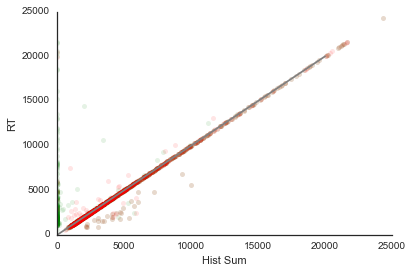

In [31]:
wh = DD_AI
ehistrange = list(map(lambda x: 'e'+str(x), list(range(36))))
mhistrange = list(map(lambda x: 'm'+str(x), list(range(36))))
D = pd.concat([wh.loc[:, ehistrange].sum(axis=1), wh.loc[:, mhistrange].sum(axis=1),
           pd.Series(wh.rt.values.astype(int), # + wh.rt_comp.values.astype(int), 
                     index=wh.index)], axis=1)
plt.plot(D.loc[:, 0], D.loc[:, 2], marker='o', alpha=.1, markersize=5, color='green', linestyle='None')
plt.plot(D.loc[:, 1], D.loc[:, 2], marker='o', alpha=.1, markersize=5, color='red', linestyle='None')
plt.plot(np.arange(0, 30000, 10000), np.arange(0, 30000, 10000), color='grey')
plt.setp(plt.gca(), xlim=[0,25000], ylim=[0,25000], xlabel='Hist Sum', ylabel='RT')
sns.despine()

0.0
0.7559115179252479


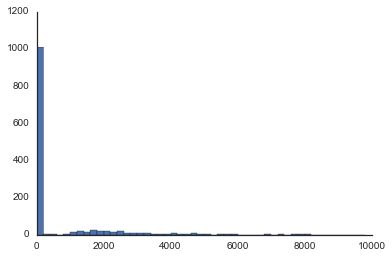

In [34]:
D.loc[:, 'rowdif'] = np.abs(D.loc[:, 0] - D.loc[:, 2])
plt.hist(D.rowdif, bins=np.arange(0, 10000, 200))
print(D.rowdif.median())
print(len(D.loc[D.rowdif<=10, :]) / len(D))
sns.despine()

In [35]:
def mouse_to_tile(x, y):
    top = 192
    bottom = 506
    left = 177
    right = 889
    height = bottom - top
    width = right - left
    newx = 9*(x - left) / width
    newy = 4*(y - top) / height

    return newx, newy

index 952
bounds 1429284430795 1429284434852
eyehist
 [[0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]]


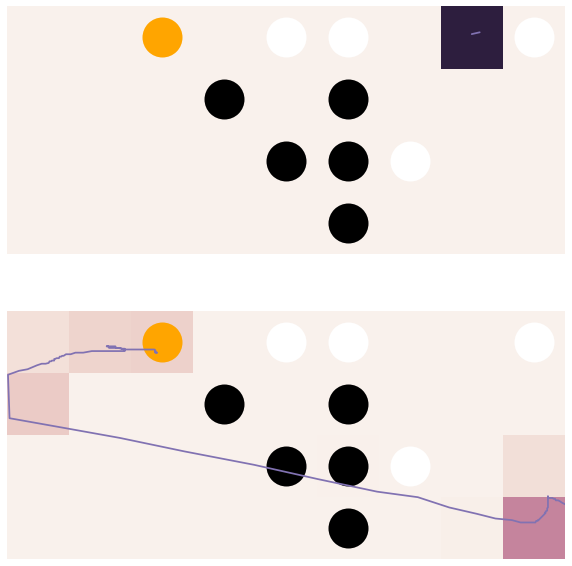

In [40]:
# good idxs: 552
bigT = pd.concat(d.tidy for d in data)
rd = DD_AI.copy().reset_index(drop=True)
eh = list(map(lambda x: 'e'+str(x), range(36)))
mh = list(map(lambda x: 'm'+str(x), range(36)))

c = rd.loc[:, eh].values.sum(axis=1)>0
rd.loc[c, eh] = rd.loc[c, eh].values / rd.loc[c, eh].values.sum(axis=1)[:, np.newaxis]
c = rd.loc[:, mh].values.sum(axis=1)>0
rd.loc[c, mh] = rd.loc[c, mh].values / rd.loc[c, mh].values.sum(axis=1)[:, np.newaxis]
hm = lambda x, y: sns.heatmap(x, ax=y, cbar=False, 
                              xticklabels=False, yticklabels=False, 
                              square=True, vmin=0, vmax=1)

probe_idx = np.random.randint(0, 1000)
print('index', probe_idx)
ms = 40
pieceplot = lambda x, y, c, ax: ax.plot(x, y, markerfacecolor=c, 
                                        markersize=ms, marker='o', 
                                        linestyle='None', markeredgecolor='black')

fig, axes = plt.subplots(2, 1, figsize=(10,10))
for i in rd.index.values[probe_idx:probe_idx + 1]:
    td = rd.loc[i, :]
    l = bigT.tstamp.values>=(int(td.tstamp_comp)+1)
    u = bigT.tstamp.values<(int(td.tstamp)+1)
    move = bigT.loc[l&u, :]
    print('bounds', td.tstamp_comp, td.tstamp)

    ehist = td[list(map(lambda x: 'e'+str(x), range(36)))].values.reshape([4,9])
    print('eyehist\n', ehist)
    mhist = td[list(map(lambda x: 'm'+str(x), range(36)))].values.reshape([4,9])
    hists = [ehist, mhist]
    
    bp = np.where(np.array(list(td.bp)).astype(int)==1)[0]
    wp = np.where(np.array(list(td.wp)).astype(int)==1)[0]
    bx, by = bp%9+.5, 3 - bp//9+.5
    wx, wy = wp%9+.5, 3 - wp//9+.5
    z = int(td.zet)
    zx, zy = z%9+.5, 3 - z//9+.5
    
    mx, my = mouse_to_tile(move.mousex.values.astype(float), move.mousey.values.astype(float))
    for j, h in enumerate(hists):
        pieceplot(bx, by, 'black', axes[j])
        pieceplot(wx, wy, 'white', axes[j])
        pieceplot(zx, zy, 'orange', axes[j])
        if j==0:
            axes[j].plot(move.eyex_tr, 4- move.eyey_tr)
#             print(move.loc[:, ['tstamp', 'eyex_tr', 'eyey_tr', 'dt']])
        else:
            axes[j].plot(mx, 4 - my)
        hm(h.astype(float), axes[j])

Summary figs

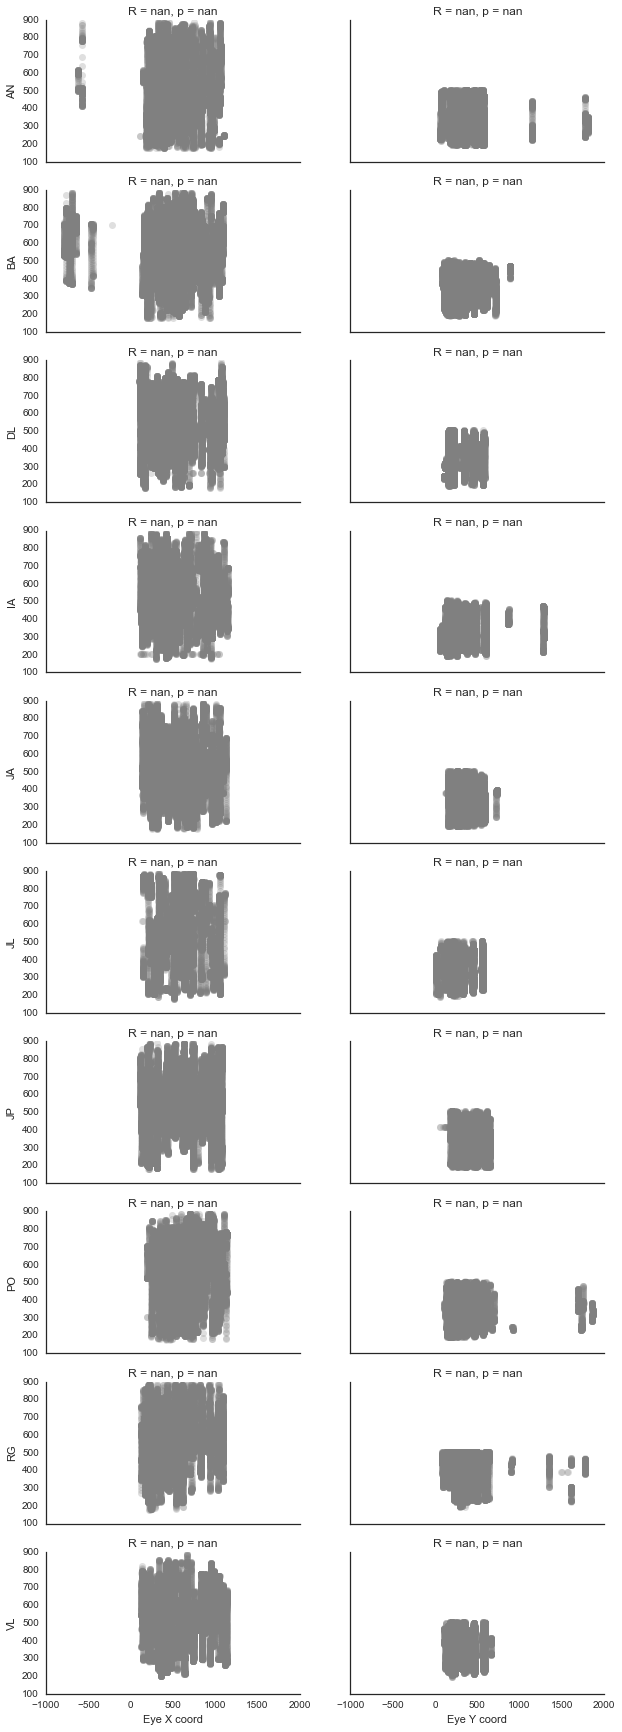

In [11]:
fig, axes = plt.subplots(len(inits), 2, figsize=(10, 30), sharex=True, sharey=True)

for i, t in enumerate(data):
    D = t.tidy #t.tidy.loc[t.tidy.status=='playing', :].copy()
    x, y = (D.eyex_raw, D.eyey_raw), (D.mousex, D.mousey)
    lr = (sts.linregress(x[0], y[0]), sts.linregress(x[1], y[1]))
    for j in [0, 1]:
        axes[i, j].plot(x[j], y[j], marker='o', markerfacecolor='grey', color='None', alpha=.25)
        axes[i, j].plot(np.arange(1200), lr[j].slope*np.arange(1200) + lr[j].intercept, 'k')
        axes[i, j].set_title('R = {0.rvalue:.2f}, p = {0.pvalue:.4f}'.format(lr[j]))
    axes[i, 0].set_ylabel(inits[i])
    
axes[-1, 0].set_xlabel('Eye X coord')
axes[-1, 1].set_xlabel('Eye Y coord')
                             
sns.despine()

fig.savefig('../../../Figures/2_eye/mouse_eye_correlation.png')

In [ ]:
pidx = 3
l = bigT.loc[pd.notnull(bigT.bp), :].index.values[pidx]
u = bigT.loc[pd.notnull(bigT.bp), :].index.values[pidx+1]
tester = bigT.loc[l:u, 
                  ['eyey_raw', 'eyex_raw', 'mousex', 'mousey', 'dt', 'etile', 'mtile']].head(200)
pd.pivot_table(tester, values='dt', index='etile')

In [ ]:
rd.loc[pidx]

Histograms